# Mixed 1D/2D modelling of a reinforced slope stability

$\newcommand{\bt}{\boldsymbol{t}}
\newcommand{\bn}{\boldsymbol{n}}
\newcommand{\bf}{\boldsymbol{f}}
\newcommand{\dx}{\,\text{dx}}
\newcommand{\dS}{\,\text{dS}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\jump}[1]{[\![#1]\!]}$

In this demo, we illustrate how we can formulate a limit analysis problem involving 1D reinforcements in a 2D solid. In the present case, we consider the slope stability problem with three horizontal reinforcements. Note that the same approach could also be used for a 2D/3D mixed modelling. However, 1D/3D mixed modelling is much more involved and cannot be tackled using the present approach.

## Mixed modelling approach

We consider a bulk solid domain $\Omega$ consisting of a material obeying the strength criterion $G$, e.g. a plane strain Mohr-Coulomb criterion in the subsequent application. The domain also consists of a set of uniaxial reinforcements $\Gamma$ of unit tangent vector $\boldsymbol{t}$. The reinforcements are assumed to be perfectly flexible so that the internal forces consist only of a normal force $N$. The latter is subjected to a uniaxial tension/compression criterion:
\begin{equation}
|N|\leq N_0
\end{equation}
where $N_0$ is the corresponding uniaxial strength.

Defining the different static variable including the bulk stress $\bsig$ and the normal force $N$ with `fenics-optim` is rather straightforward. It therefore essentially remains the question of imposing the equilibrium equations. We have inside the bulk $\Omega$:
\begin{equation}
\operatorname{div} \bsig + \lambda \bf =0
\end{equation}
where $\lambda\bf$ denotes the body force.

We also have on $\Gamma$, the normal force equibrium:
\begin{equation}
\dfrac{d(N\bt)}{d s} + \jump{\bsig}\cdot\bn = 0
\end{equation}
where $\jump{\bsig} = \bsig^\oplus - \bsig^\ominus$ denotes the stress jump through $\Gamma$, $\bn$ denotes the unit normal to $\Gamma$ and $s$ is the curvilinear coordinate along $\Gamma$.

The above strong equilibrium equations can be enforced directly using a cell and a facet Lagrange multipliers respectively, as in a lower bound static approach. Alternatively, it can also be enforced weakly as in upper bound kinematic approaches written in a static form. In the latter case, considering a continuous virtual displacement $\bu$, the virtual work principle reads:
\begin{equation}
\int_\Omega \bsig:\nabla^s \bu \dx + \int_{\Gamma} N\bt\cdot \dfrac{d\bu}{ds} \dS = \lambda \int_\Omega \bf \cdot\bu \dx
\end{equation}
and, since $\dfrac{d\bu}{ds} = \dfrac{d\bu}{d\bx}\cdot\bt$, it also reads:
\begin{equation}
\int_\Omega \bsig:\nabla^s \bu \dx + \int_{\Gamma} N\bt \otimes \bt : \nabla^s \bu \dS = \lambda \int_\Omega \bf \cdot\bu \dx
\end{equation}

## Implementation

As mentioned above, we consider a vertical slope stability problem under self-weigth loading. The slope is reinforced by an array of uniaxial reinforcements of length $L_\text{reinf}$ located at the heights $H/4, H/2, 3H/4$. We first define the soil mesh and identify the regions corresponding to the fixed boundary conditions and the reinforcement locations. In particular, the reinforcements $\Gamma$ will correspond to the facet tag `2`.

In [14]:
from dolfin import (
    RectangleMesh,
    Point,
    FacetNormal,
    near,
    MeshFunction,
    Measure,
    dx,
    AutoSubDomain,
    Constant,
    DirichletBC,
    FunctionSpace,
    VectorFunctionSpace,
    plot,
)
from ufl import sym, dot, inner, avg, grad, pi, perp, outer
from fenics_optim import MosekProblem, to_mat
import fenics_optim.limit_analysis as la
import matplotlib.pyplot as plt

Nmesh = 100
L, H = 1.2, 1.0
L_reinf = 0.8

mesh = RectangleMesh(Point(0, 0), Point(L, H), Nmesh, Nmesh, "crossed")


def border(x, on_boundary):
    return near(x[1], 0) or near(x[0], 0)


reinf_heights = [H / 4, H / 2, 3 * H / 4]


def reinforcement(x, on_boundary):
    return any([near(x[1], Hi) for Hi in reinf_heights]) and (L - L_reinf <= x[0] <= L)


facets = MeshFunction("size_t", mesh, 1)
AutoSubDomain(border).mark(facets, 1)
AutoSubDomain(reinforcement).mark(facets, 2)
ds = Measure("ds", subdomain_data=facets, domain=mesh)
dS = Measure("dS", subdomain_data=facets, domain=mesh)

We then define the loading, the soil Mohr-Coulomb strength criterion and the reinforcement strength $N_0$.

In [15]:
f = Constant((0.0, -1.0))

c, phi = 1.0, 30 * pi / 180
mat = la.MohrCoulomb2D(c, phi)

N0 = 1.0

We then define the various function spaces which will be used to define the variables and constraint Lagrange multipliers. We use `DG 0` spaces for the stress and the normal force and a `CG 1` space for the displacement Lagrange multiplier. Note that since $N$ lives on mesh facets only, we use a `Discontinuous Lagrange Trace` space. Although $\Gamma$ corresponds only to a subspace of the mesh facets, the use of such a space will define $N$ everywhere on the mesh facets. As a result, a drawback of this approach is  that dummy variables corresponding to $N$ outside $\Gamma$ are created. This is however not an issue as the above integral will be performed only on the measure `dS(2)` corresponding to $\Gamma$ and because solvers such as Mosek are able to identify such unused variables and remove them from the final optimization problem. Finally, we use the variable lower bound `lx` and upper bound `ux` keyword to enforce the uniaxial strength criterion $|N|\leq N_0$.

In [16]:
R = FunctionSpace(mesh, "R", 0)
Wsig = VectorFunctionSpace(mesh, "DG", 0, dim=3)
WN = FunctionSpace(mesh, "Discontinuous Lagrange Trace", 0)
V = VectorFunctionSpace(mesh, "Lagrange", 1)

prob = MosekProblem("Limit analysis with reinforcements")

lamb, Sig, N = prob.add_var([R, Wsig, WN], lx=[None, None, -N0], ux=[None, None, N0])


We now express the above equilibrium weak form. Note that internal facet integrals must be restricted. In the present case, the integrand is only well defined on the facet itself so that the choice of the restriction operator has no influence. For the facet tagent vector, we use UFL's `perp` function on the mesh `FacetNormal`.

In [17]:
sig = to_mat(Sig)
n = FacetNormal(mesh)
tang = perp(n)

def equilibrium(v):
    return (
        inner(sig, sym(grad(v))) * dx
        + inner((N * outer(tang, tang))("+"), grad(v)("+")) * dS(2)
        - lamb * dot(v, f) * dx
    )


bc = DirichletBC(V, Constant((0.0, 0.0)), border)
prob.add_eq_constraint(V, A=equilibrium, name="Pseudo-mechanism", bc=bc)

We finish with defining the objective function $\lambda$, applying the Mohr-Coulomb criterion to the bulk stress and calling the solver.

In [18]:
prob.add_obj_func([1, None])

crit = mat.criterion(Sig)
prob.add_convex_term(crit)

prob.optimize(sense="maximize")

Matrix shape: (160402, 300201)
Number of cones: 40000
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 160402          
  Cones                  : 40000           
  Scalar variables       : 300201          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Eliminator started.
Freed constraints in eliminator : 80000
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 0                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.41    
GP based matrix reordering started.
GP based matrix reordering terminated.
Proble

16.338902894084487

The collapse mechanism $\bu$ clearly shows the restraining effect of the reinforcements.

Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.


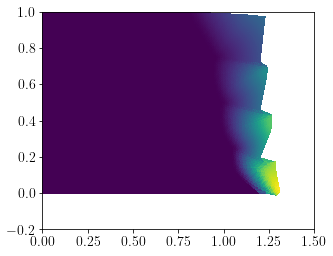

In [21]:
u = prob.get_lagrange_multiplier("Pseudo-mechanism")
plot(-0.004 * u, mode="displacement")
plt.show()